<a href="https://colab.research.google.com/github/Stacy067/Advanced-Macroeconomics/blob/main/TF_Certificate_Category_3_(%EA%B0%95%EC%9D%98)_rps%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Category 3

Convolution Neural Network (합성곱 신경망)를 활용한 이미지 분류 (Image Classification)

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

For this task you will build a classifier for Rock-Paper-Scissors 
based on the rps dataset.

IMPORTANT: Your final layer should be as shown, do not change the
provided code, or the tests may fail

IMPORTANT: Images will be tested as 150x150 with 3 bytes of color depth
So ensure that your input layer is designed accordingly, or the tests
may fail. 

NOTE THAT THIS IS UNLABELLED DATA. 
You can use the ImageDataGenerator to automatically label it
and we have provided some starter code.

-------------------------------

이 작업에서는 Rock-Paper-Scissors에 대한 분류기를 작성합니다.
rps 데이터 셋을 기반으로합니다.

중요 : 최종 레이어는 그림과 같아야합니다.

중요 : 이미지는 3 바이트 150x150의 컬러사진으로 테스트됩니다.
따라서 입력 레이어가 그에 따라 설계되었거나 테스트되었는지 확인하십시오.

ImageDataGenerator를 사용하여 자동으로 레이블을 지정할 수 있습니다.

-----------------------------------


## 필요한 모듈 import 하기

In [1]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

## Dataset 로드

가위바위보에 대한 손의 사진을 가지고 `가위`인지, `바위`인지, `보자기`인지 분류하는 `classification` 문제입니다.

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

## STEP 2. Define Folder

데이터셋의 경로를 지정해 주세요 (root 폴더의 경로를 지정하여야 합니다.)


In [3]:
# training dir
TRAINING_DIR = "tmp/rps/"

## STEP 3. ImageDataGenerator

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

In [4]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.2
    )
# 증명 사진의 경우 여기에 있는 값 줄임, 일반 사진은 숫자를 넓게, data에 따라 달라짐

## STEP 4. Make Generator

ImageDataGenerator를 잘 만들어 주었다면, `flow_from_directory`로 이미지를 어떻게 공급해 줄 것인가를 지정해 주어야합니다.

* train / validation set 전용 generator를 별도로 정의합니다.
* `batch_size`를 정의합니다. (32)
* `target_size`를 정의합니다. (150 x 150). 이미지를 알아서 타겟 사이즈 만큼 잘라내어 공급합니다.
* `class_mode`는 출력층의 **activation**이 `softmax`인 경우 'categorical', `sigmoid`인 경우 'binary'를 지정합니다.
* `subset`을 지정합니다. (training / validation)


**training_generator**에 대한 `from_from_directory`를 정의합니다.

In [5]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=32, 
                                                          target_size=(150, 150), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 2016 images belonging to 3 classes.


**validation_generator**에 대한 `from_from_directory`를 정의합니다.

In [6]:
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=32, 
                                                          target_size=(150, 150), 
                                                          class_mode='categorical',
                                                          subset='validation', 
                                                         )

Found 504 images belonging to 3 classes.


504 개의 이미지가 출력되어야 합니다.

### 시각화 해보기

오리지널 사진 파일
Found 2520 images belonging to 3 classes.
(128, 150, 150, 3) (128, 3)
[0. 0. 1.]


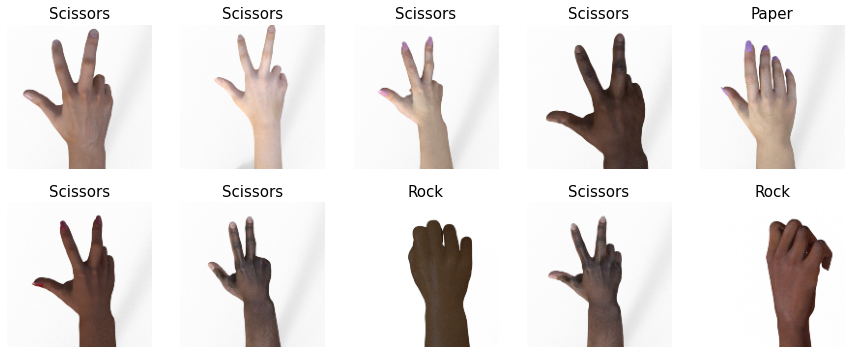

Augmentation 적용한 사진 파일
(32, 150, 150, 3) (32, 3)
[0. 1. 0.]


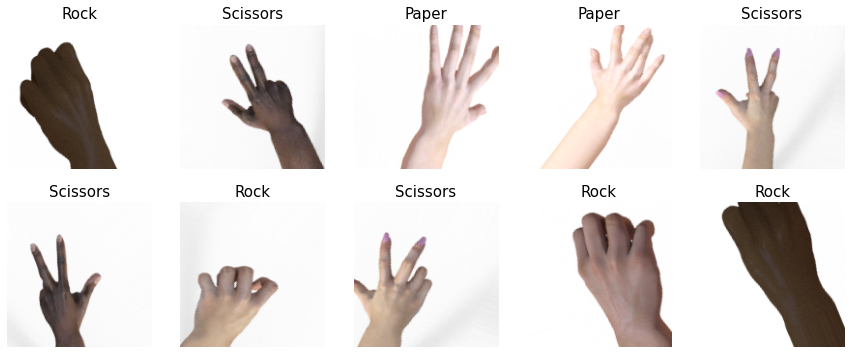

In [7]:
import matplotlib.pyplot as plt

class_map = {
    0: 'Paper',
    1: 'Rock', 
    2: 'Scissors'
}

print('오리지널 사진 파일')

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(150, 150), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    plt.show()
    break
    
print('Augmentation 적용한 사진 파일')
    
for x, y in training_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    
    plt.show()
    break

### Convolution Neural Network (CNN)

**CNN - activation - Pooling** 과정을 통해 이미지 부분 부분의 **주요한 Feature 들을 추출**해 냅니다.

CNN을 통해 우리는 다양한 1개의 이미지를 `filter`를 거친 다수의 이미지로 출력합니다.

`filter`의 사이즈는 **3 X 3 필터**를 자주 사용합니다

또한, 3 X 3 필터를 거친 이미지의 사이즈는 **2px 만큼 사이즈가 줄어듭니다**.

[CNN Filter 예시](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

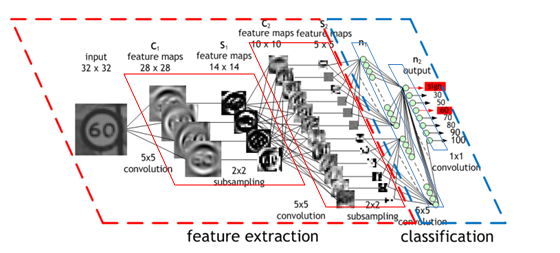

In [8]:
Image('https://devblogs.nvidia.com/wp-content/uploads/2015/11/fig1.png', width=800)

## 이미지 특성 추출: Conv2D

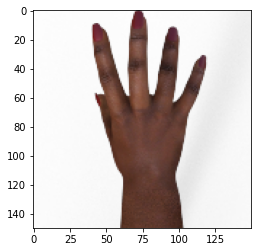

In [9]:
for x, y in original_generator:
    pic = x[:5]
    break
    
plt.imshow(pic[0])

In [10]:
conv2d = Conv2D(64, (3, 3), input_shape=(150, 150, 3))
conv2d_activation = Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3))

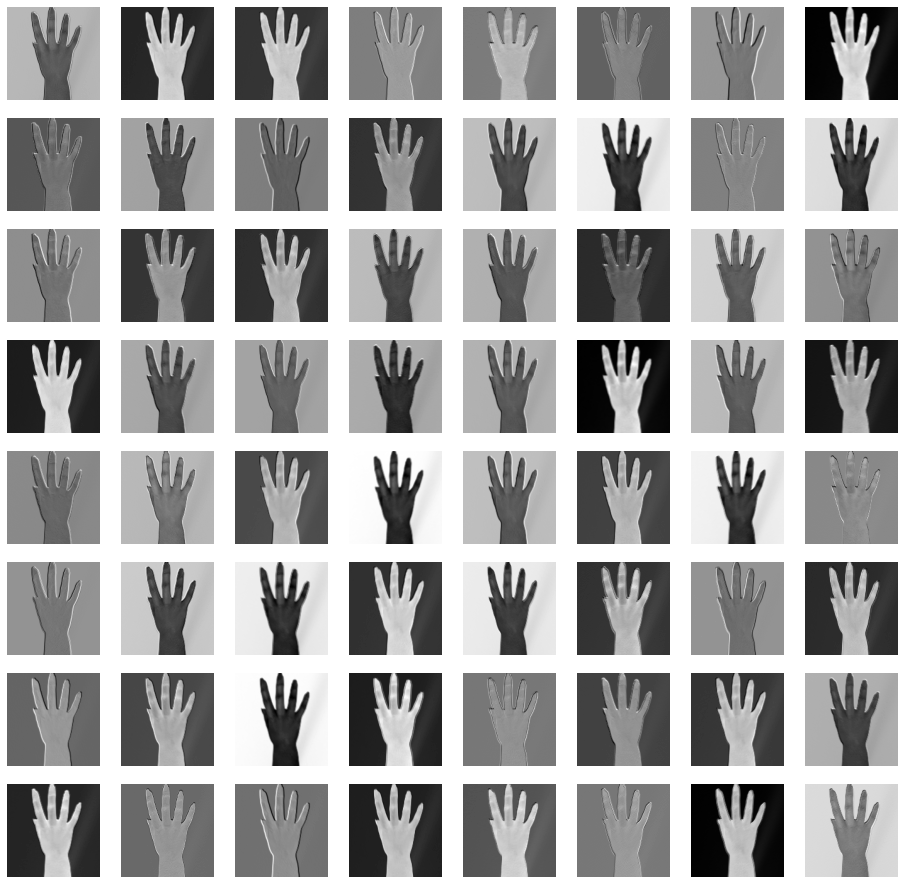

In [11]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16, 16)
for i in range(64):
    axes[i//8, i%8].imshow(conv2d(pic)[0,:,:,i], cmap='gray')
    axes[i//8, i%8].axis('off')

## 이미지 특성 추출: MaxPooling2D

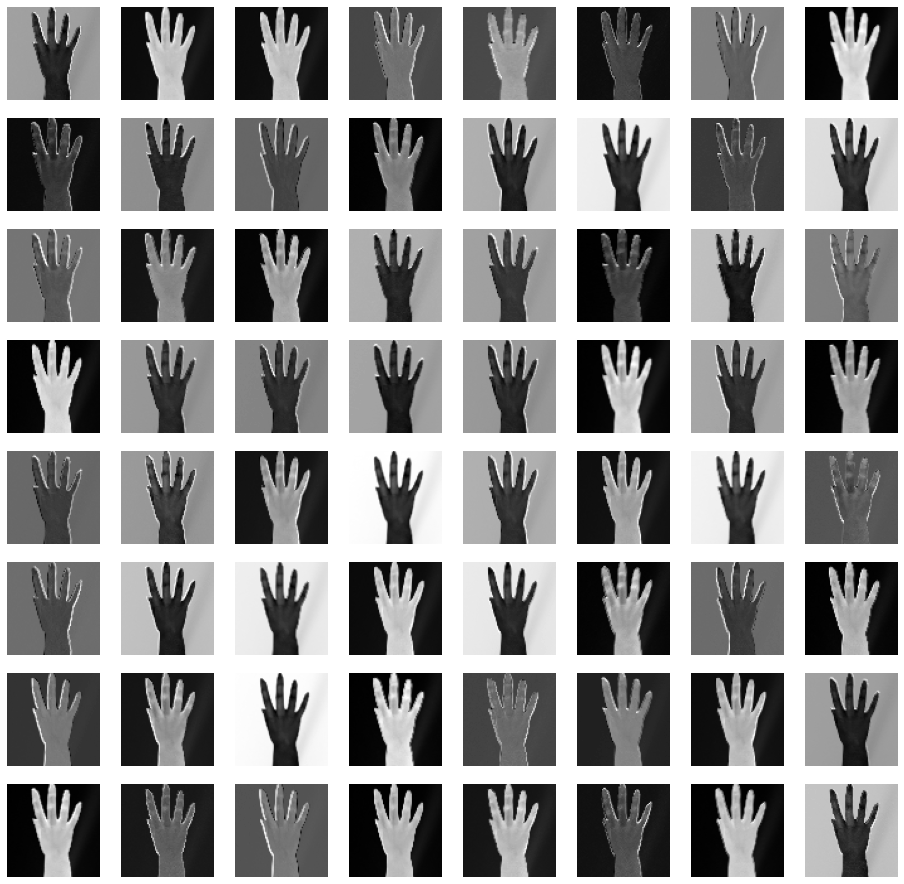

In [12]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(16, 16)
for i in range(64):
    axes[i//8, i%8].imshow(MaxPooling2D(2, 2)(conv2d(pic))[0, :, :, i], cmap='gray')
    axes[i//8, i%8].axis('off')

## 단계별 특성 추출 과정

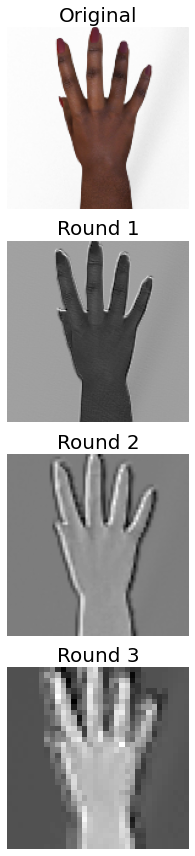

In [14]:
conv1 = Conv2D(64, (3, 3), input_shape=(150, 150, 3))(pic)
max1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(64, (3, 3))(max1)
max2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, (3, 3))(max2)
max3 = MaxPooling2D(2, 2)(conv3)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6, 12)
axes[0].set_title('Original', fontsize=20)
axes[0].imshow(pic[0])
axes[0].axis('off')
axes[1].set_title('Round 1', fontsize=20)
axes[1].imshow( conv1[0, :, :, 0], cmap='gray')
axes[1].axis('off')
axes[2].set_title('Round 2', fontsize=20)
axes[2].imshow( conv2[0, :, :, 0], cmap='gray')
axes[2].axis('off')
axes[3].set_title('Round 3', fontsize=20)
axes[3].imshow( conv3[0, :, :, 0], cmap='gray')
axes[3].axis('off')
plt.tight_layout()
plt.show()

## 모델 정의 (Sequential)

In [15]:
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (150, 150, 3)으로 지정합니다.
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(), 
    # 과적합 방지를 위하여 Dropout을 적용합니다.
    Dropout(0.5),
    Dense(512, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (3개), activation도 잊지마세요!
    Dense(3, activation='softmax'),
])

In [16]:
model.summary() # parameter는 연산량

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 17, 17, 128)      0

## 컴파일 (compile)

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`설정
  * 출력층 activation이 `sigmoid` 인 경우: `binary_crossentropy`
  * 출력층 activation이 `softmax` 인 경우: 
    * 원핫인코딩(O): `categorical_crossentropy`
    * 원핫인코딩(X): `sparse_categorical_crossentropy`)
3. 참고: `ImageDataGenerator`는 자동으로 Label을 **원핫인코딩(one-hot encoding)** 해줍니다.
4. `metrics`를 'acc' 혹은 'accuracy'로 지정하면, 학습시 정확도를 모니터링 할 수 있습니다.

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

## ModelCheckpoint: 체크포인트 생성

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [18]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## 학습 (fit)

In [19]:
epochs=25

In [20]:
history = model.fit(training_generator, 
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint],
                    )

Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 1.0878 - acc: 0.3849
Epoch 1: val_loss improved from inf to 1.04504, saving model to tmp_checkpoint.ckpt
63/63 [==============================] - 23s 322ms/step - loss: 1.0878 - acc: 0.3849 - val_loss: 1.0450 - val_acc: 0.3829
Epoch 2/25
63/63 [==============================] - ETA: 0s - loss: 0.7530 - acc: 0.6543
Epoch 2: val_loss improved from 1.04504 to 0.94272, saving model to tmp_checkpoint.ckpt
63/63 [==============================] - 20s 313ms/step - loss: 0.7530 - acc: 0.6543 - val_loss: 0.9427 - val_acc: 0.5813
Epoch 3/25
63/63 [==============================] - ETA: 0s - loss: 0.5666 - acc: 0.7604
Epoch 3: val_loss improved from 0.94272 to 0.86396, saving model to tmp_checkpoint.ckpt
63/63 [==============================] - 20s 322ms/step - loss: 0.5666 - acc: 0.7604 - val_loss: 0.8640 - val_acc: 0.7004
Epoch 4/25
63/63 [==============================] - ETA: 0s - loss: 0.3411 - acc: 0.8695
Epoch 4: val_loss 

## 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

In [21]:
model.load_weights(checkpoint_path)

## 학습 오차에 대한 시각화

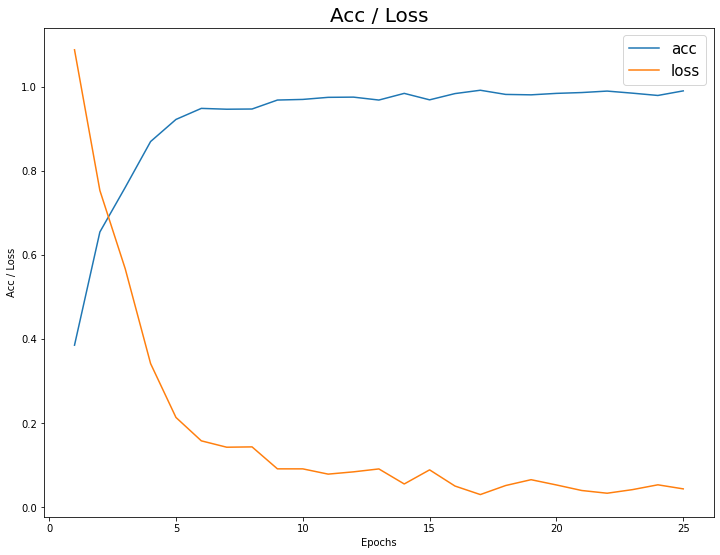

In [22]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.title('Acc / Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc / Loss')
plt.legend(['acc', 'loss'], fontsize=15)
plt.show()